In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import sobel
import os
import cv2
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout, Activation, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
import tensorflow_addons as tfa

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

from tensorflow.keras import backend as K
from focal_loss import BinaryFocalLoss

import rasterio

In [2]:
# Load the .h5 file
image_folder = "/VSCode/Senior Project/TrainData/img"
mask_folder = "/VSCode/Senior Project/TrainData/mask"

image_files = sorted(glob.glob(os.path.join(image_folder, "*.h5")))
mask_files = sorted(glob.glob(os.path.join(mask_folder, "*.h5")))

image_files = image_files[:2500]
mask_files = mask_files[:2500]

images = []
masks = []

images_training = []
masks_training =[]
testing_images = []
testing_masks = []

for img_path, mask_path in zip(image_files, mask_files):

    # Load image
    with h5py.File(img_path, "r") as img_file:
        if "img" in img_file:
            image_data = img_file["img"][:]
            images.append(image_data)
        else:
            print(f"No dataset named 'data' found in {img_path}")
    
    # Load mask
    with h5py.File(mask_path, "r") as mask_file:
        if "mask" in mask_file:
            mask_data = mask_file["mask"][:]
            masks.append(mask_data)
        else:
            print(f"No dataset named 'data' found in {mask_path}")

images = np.array(images)
masks = np.array(masks)

print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")

Images shape: (2500, 128, 128, 14)
Masks shape: (2500, 128, 128)


In [ ]:
training_images = np.array(images[:2000])
training_masks = np.array(masks[:2000])

testing_images = np.array(images[2000:2500])
testing_masks = np.array(masks[2000:2500])

In [ ]:
# Definitions for each function

def conv_block(inputs, filters, kernel_size=(3,3), padding="same"):
    x = layers.Conv2D(filters, kernel_size, padding=padding, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = layers.Conv2D(filters, kernel_size, padding=padding, activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def unet_plus_plus(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)
    
    # Encoding Path
    x_00 = conv_block(inputs, 64)
    x_10 = conv_block(MaxPooling2D()(x_00), 128)
    x_20 = conv_block(MaxPooling2D()(x_10), 256)
    x_30 = conv_block(MaxPooling2D()(x_20), 512)
    x_40 = conv_block(MaxPooling2D()(x_30), 1024)
 
    # Decoding Path
    x_01 = conv_block(concatenate(
        [x_00, UpSampling2D()(x_10)]), 64)
    x_11 = conv_block(concatenate(
        [x_10, UpSampling2D()(x_20)]), 128)
    x_21 = conv_block(concatenate(
        [x_20, UpSampling2D()(x_30)]), 256)
    x_31 = conv_block(concatenate(
        [x_30, UpSampling2D()(x_40)]), 512)
 
    x_02 = conv_block(concatenate(
        [x_00, x_01, UpSampling2D()(x_11)]), 64)
    x_12 = conv_block(concatenate(
        [x_10, x_11, UpSampling2D()(x_21)]), 128)
    x_22 = conv_block(concatenate(
        [x_20, x_21, UpSampling2D()(x_31)]), 256)
 
    x_03 = conv_block(concatenate(
        [x_00, x_01, x_02, UpSampling2D()(x_12)]), 64)
    x_13 = conv_block(concatenate(
        [x_10, x_11, x_12, UpSampling2D()(x_22)]), 128)
 
    x_04 = conv_block(concatenate(
        [x_00, x_01, x_02, x_03, UpSampling2D()(x_13)]), 64)

    # Output layer
    outputs = Conv2D(1, (1,1), activation="sigmoid")(x_04)

    model = Model(inputs, outputs)
    return model

def iou_metric(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred) - intersection
    return intersection / (union + tf.keras.backend.epsilon())

def resize_patch(image, target_size):
    return cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)

# recall 
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#f1 score
def f1_score_custom(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    return 2 * (precision * recall) / (precision + recall + K.epsilon())

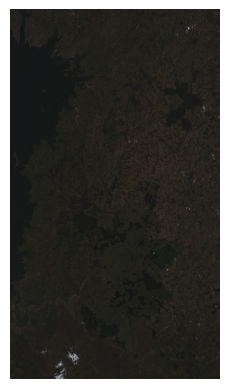

(14, 6197, 3505)


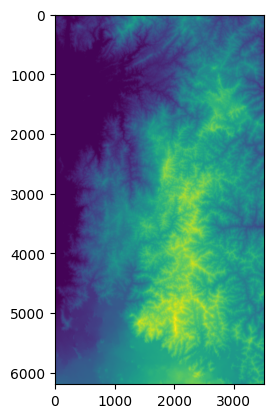

In [ ]:
# Path to the downloaded GeoTIFF
# tiff_path = '/VSCode/Senior Project/Sentinel2_B1toB12_Slope_DEM_Aligned-0000000000-0000000000.tif'
# tiff_path = '/VSCode/Senior Project/Sentinel2_B1toB12_Slope_DEM_Aligned-0000006656-0000006656.tif'
tiff_path = '/VSCode/Senior Project/Sentinel2_B1toB12_Slope_DEM_Aligned.tif'

# Read the raster
with rasterio.open(tiff_path) as src:
    img_data = src.read()

# Band 10 is missing, so we need to fill it in
band_10_filled = np.zeros_like(img_data[0, :, :])

# Add Band 10 back into the image data at index 9
img_data_with_b10 = np.insert(img_data, 9, band_10_filled, axis=0)
img_data_with_b10 = np.nan_to_num(img_data_with_b10, nan=0)
#img_data_with_b10[[12, 13]] = img_data_with_b10[[13, 12]]
RGB_sample = img_data_with_b10

rgb_image = np.stack([
    img_data[3],  # Red
    img_data[2],  # Green
    img_data[1]   # Blue
], axis=-1)
rgb_image = rgb_image / np.max(rgb_image)
plt.imshow(rgb_image)
plt.axis('off')
plt.show()


In [7]:
epsilon = 1e-6

dem = img_data_with_b10[13]
slopes_org = img_data_with_b10[12]

red_band = img_data_with_b10[3]
green_band = img_data_with_b10[2]
blue_band = img_data_with_b10[1]
nir_band = img_data_with_b10[7]


ndvi = (nir_band - red_band) / (nir_band + red_band + epsilon)

img_B_model_data = np.stack([red_band, green_band, blue_band, ndvi, dem, slopes_org], axis=-1)

print(img_B_model_data.shape)


(6197, 3505, 6)


In [ ]:
def split_into_patches(data, patch_size=128):
    patches = []
    
    # Loop over the image and extract 128x128 patches
    for i in range(0, data.shape[0], patch_size):
        for j in range(0, data.shape[1], patch_size):
            # Slice out each patch
            patch = data[i:i+patch_size, j:j+patch_size, :]
            if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                patches.append(patch)
    
    # Convert to numpy
    return np.array(patches)

# Use function
patches = split_into_patches(img_B_model_data)

(1296, 128, 128, 6)


In [10]:
# Standardize per channel
mean = patches.mean(axis=(0,1,2))
std = patches.std(axis=(0,1,2))

# Apply normalization
patches_normalized = (patches - mean) / std

print(patches.mean(axis=(0,1,2)))
print(img_B_model_data.mean(axis=(0,1)))
img_B_mean = img_B_model_data.mean(axis=(0,1))
img_B_std = img_B_model_data.std(axis=(0,1))

img_B_model_data_normalized = (img_B_model_data - img_B_mean) / img_B_std


[1.75011951e+03 1.68626782e+03 1.45367952e+03 3.08349034e-01
 2.05657194e+03 1.54491189e+01]
[1.75450101e+03 1.68921089e+03 1.45647425e+03 3.08330572e-01
 2.05905271e+03 1.54721289e+01]


In [ ]:
def sliding_window_prediction(image, model, patch_size=128, stride=64):
    h, w, c = image.shape
    output = np.zeros((h, w), dtype=np.float32)
    count = np.zeros((h, w), dtype=np.float32)

    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            patch = image[i:i+patch_size, j:j+patch_size, :]
            
            # Expand dimensions
            patch_input = np.expand_dims(patch, axis=0)
            
            # Predict
            pred = model.predict(patch_input, verbose=0)
            pred = np.squeeze(pred)  # Shape: (128, 128)
            
            output[i:i+patch_size, j:j+patch_size] += pred
            count[i:i+patch_size, j:j+patch_size] += 1

    # Avoid division by zero
    count[count == 0] = 1

    # Normalize to average overlapping regions
    final_prediction = output / count
    return final_prediction

model_path = '/VSCode/Senior Project/TrainedModels/O_models/O_model_epoch_50.keras'
model = load_model(model_path, custom_objects={'f1_score_custom': f1_score_custom, 'iou_metric': iou_metric})

final_pred = sliding_window_prediction(img_B_model_data_normalized, model, patch_size=128, stride=64)

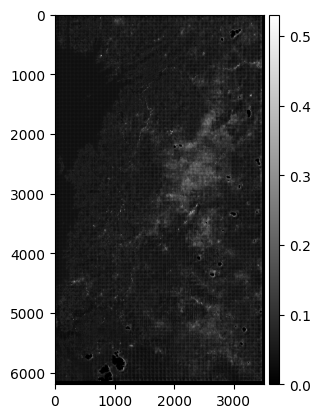

In [ ]:
fig, ax = plt.subplots()

# Show the image
im = ax.imshow(final_pred, cmap='gray')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Create the colorbar
cbar = plt.colorbar(im, cax=cax)

plt.show()